In [1]:
import os
import time
import numpy as np
import xgboost as xgb
from imp import reload
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import importdata
import MachineLearning as ML
import eli5

reload(importdata)
reload(ML)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [91]:
def mass_plot(data,label='Result'):
    
    mass_pred = data['predict']
    mass_test = data['test']
    
    try:
        mse = data.meta['MSE']
        mae = data.meta['MAE']
        Rsq = data.meta['R2']
    except (KeyError, AttributeError):
        # Calculate test MSE (mean squared error) 
        SSres = np.sum((mass_pred - mass_test)**2)
        mse = SSres/len(mass_test)
    
        # Calculate coefficient of determination
        SStot = np.sum((mass_test - mass_test.mean())**2)
        Rsq = 1-SSres/SStot
        
        # Calculate median absolute error
        mae = np.median(np.abs(mass_pred-mass_test))
    
    # Define outliers
    res = np.abs(mass_pred-mass_test)
    threshold = 2*np.std(mass_test)
    outlier = res > threshold
    outrate = np.sum(outlier)/len(mass_pred)
    
    plt.figure(figsize=(18,5.5))
    # Scatter plot of mass_predict vs. mass_test
    ax1 = plt.subplot(131)
    ax1.scatter(mass_test[outlier][::10], mass_pred[outlier][::10], s=0.5, c='r')
    ax1.scatter(mass_test[~outlier][::10], mass_pred[~outlier][::10], s=0.5)
    ax1.plot(np.arange(20),np.arange(20),'k-.',linewidth=0.5)
    ax1.plot(np.arange(20),np.arange(20)+threshold,'k-.',linewidth=1)
    ax1.plot(np.arange(20),np.arange(20)-threshold,'k-.',linewidth=1)
    ax1.set_title(f'Coefficient of determination = {Rsq:.4f}'+'\n'
                  '$f_{outlier}$ = '+f'{outrate*100:.2f}%')
    xrange=(7,13)
    yrange=(7,13)
    ax1.set_xlim(xrange)
    ax1.set_ylim(yrange)
    ax1.set_xlabel('Mass test', fontsize=12)
    ax1.set_ylabel('Mass predict', fontsize=12)
    ax1.grid(alpha = 0.6)
    
    ax2 = plt.subplot(132)
    ax2.scatter(mass_test[outlier][::10],
                mass_pred[outlier][::10]-mass_test[outlier][::10], s=0.5, c='r')
    ax2.scatter(mass_test[~outlier][::10],
                mass_pred[~outlier][::10]-mass_test[~outlier][::10], s=0.5)
    xrange=(7,13)
    ax2.hlines(xmin=xrange[0], xmax=xrange[1], y=0, linestyle='-.', linewidth=0.5)
    ax2.hlines(xmin=xrange[0], xmax=xrange[1], y=threshold, linestyle='-.', linewidth=1)
    ax2.hlines(xmin=xrange[0], xmax=xrange[1], y=-threshold, linestyle='-.', linewidth=1)
    ax2.set_xlim(xrange)
    ax2.set_xlabel('Mass test', fontsize=12)
    ax2.set_ylabel('Mass residual', fontsize=12)
    ax2.set_title(f'Mean squared error = {mse:.4f}'+'\n'
                  '$f_{outlier}$ = '+f'{outrate*100:.2f}%')
    ax2.grid(alpha = 0.6)

    ax3 = plt.subplot(133)
    ax3.hist(mass_pred, bins=[7+x*0.06 for x in range(100)], histtype='step', label='Prediction')
    ax3.hist(mass_test, bins=[7+x*0.06 for x in range(100)], histtype='step', label='Test')
    ax3.legend()
    ax3.set_xlabel('logM', fontsize=12)
    ax3.set_title('Distribution of mass', fontsize=12)
    
    plt.savefig(label+'_plot.png')


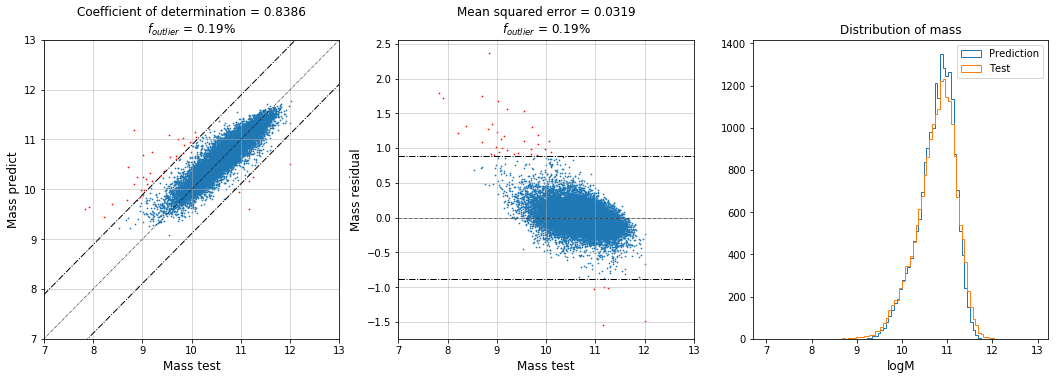

In [76]:
mass_plot(test)

In [10]:
reg = ML.Regressors(col_shape, decals['mass_ir'], train_size=0.8, test_size=0.2, random_state=2)
test = reg.KNN_dregressor(cross_validation=True)

In [6]:
decals = importdata.importdata()

/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [7]:
# Drop data with really small redshift which may be some nearby stars, not galaxies
decals=decals[np.log10(decals['redshift'])>-1.5]

In [8]:
len(decals)

498255

Preparing input data

In [16]:
color = np.column_stack((decals['gmag']-decals['rmag'], decals['rmag']-decals['zmag'],
                         decals['zmag']-decals['w1mag'], decals['w1mag']-decals['w2mag'],
                         decals['w2mag']))
grmag = np.column_stack((decals['gmag']-decals['rmag'], decals['rmag']))
rzmag = np.column_stack((decals['rmag']-decals['zmag'], decals['zmag']))
zw1mag = np.column_stack((decals['zmag']-decals['w1mag'], decals['w1mag']))
w1w2mag = np.column_stack((decals['w1mag']-decals['w2mag'], decals['w2mag']))

col_shape = np.column_stack((decals['gmag']-decals['rmag'], decals['rmag']-decals['zmag'],
                             decals['zmag']-decals['w1mag'], decals['w1mag']-decals['w2mag'],
                             decals['gmag'], decals['axis_ratio'], decals['p_exp'], decals['radius']))

Distribution of true masses

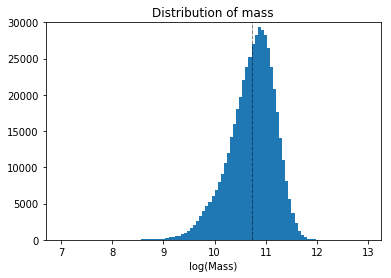

In [159]:
plt.hist(decals['mass_ir'], bins=[7+x*0.06 for x in range(100)], label='Test')
plt.ylim(0,30000)
plt.xlabel('log(Mass)',fontsize=10)
plt.title('Distribution of mass', fontsize=12)
#plt.savefig('Distribution of mass.pdf')
plt.vlines(x=decals['mass_ir'].mean(), ymin=0, ymax=32000, linestyle='-.', linewidth=0.5)

# Apply KNN, RF and XGB regression

In [17]:
# Creat Regressors class 
# this class contains several machinelearning methods and
# can automatically splits and scales input data
reg = ML.Regressors(col_shape, decals['mass_ir'])

In [19]:
# Run K nearest neighbor regression
knn = reg.KNN_dregressor(cross_validation=True, scoring=True, n_neighbors=26)

In [ ]:
# Run random forest regression
rf = reg.RFregressor(cross_validation=True, scoring=True, n_estimators=60, max_depth=18)

In [ ]:
xgb = reg.Xgboostregressor(cross_validation=True, scoring=True, max_depth=9, min_child_weight=6)

In [20]:
knn = Table.read('KNN_result.ecsv')
rf = Table.read('RF_result.ecsv')
xgb = Table.read('XGB_result.ecsv')

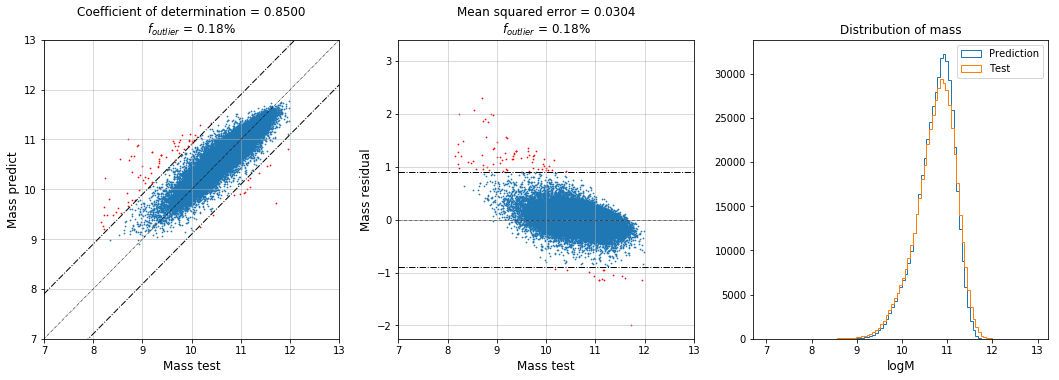

In [92]:
# Plot K nearest neighbor result
mass_plot(knn,'KNN')

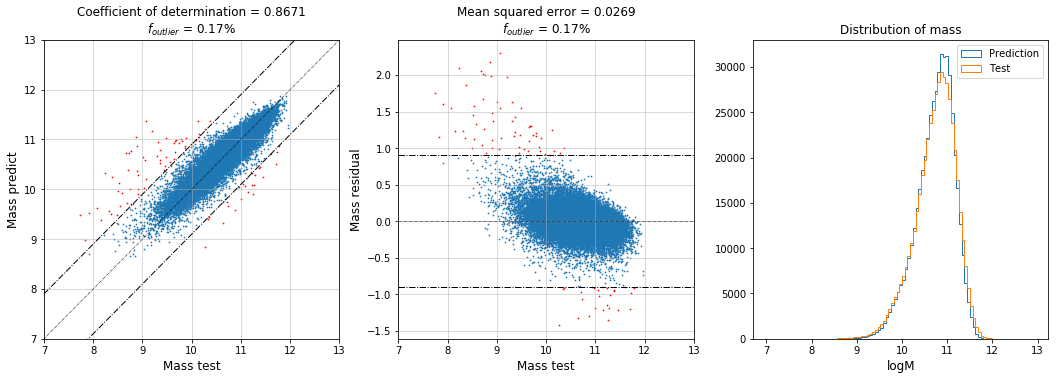

In [93]:
# Plot random forest cross-validation result
mass_plot(rf,'RF')

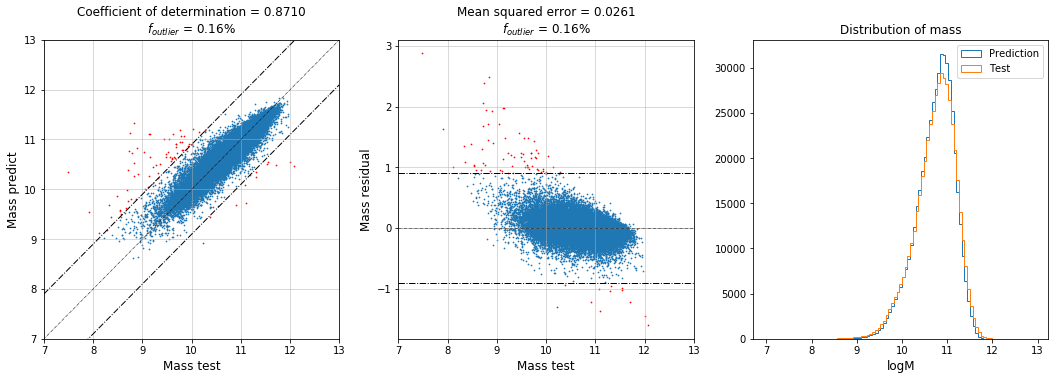

In [94]:
# Plot xgboost cross-validation result
mass_plot(xgb,'XGB')

In [223]:
regressor = ['K nearest neighbors', 'Random Forest', 'Xgboost']
R2 = np.round([knn.meta['R2'], rf.meta['R2'], xgb.meta['R2']],4)
MSE = np.round([knn.meta['MSE'], rf.meta['MSE'], xgb.meta['MSE']],4)
MAE = np.round([knn.meta['MAE'], rf.meta['MAE'], xgb.meta['MAE']],4)
time = np.round([knn.meta['fit_time'], rf.meta['fit_time'], xgb.meta['fit_time']],4)
summary = Table([regressor, R2, MSE, MAE, time],
                names=['Regressor','R^2','MSE','MAE','Training time'])

In [312]:
summary

Regressor,R^2,MSE,MAE,Training time
str19,float64,float64,float64,float64
K nearest neighbors,0.85,0.0304,0.0917,0.6538
Random Forest,0.8671,0.0269,0.0838,220.2806
Xgboost,0.871,0.0261,0.0828,304.7616


# Optimize Random Forest parameters

In [359]:
depth = np.arange(8,32,2)
n_tree = np.arange(10,70,5)
rf_opt = np.zeros((len(n_tree),len(depth))).tolist()

In [360]:
start = time.time()
for i in range(len(depth)):
    for j in range(len(n_tree)):
        regrf = ML.RandomForestRegressor(n_estimators=n_tree[j],
                                         max_depth=depth[i],
                                         max_features='auto')
        score = ML.Regressors.CV_scoring(regrf, col_shape, decals['mass_ir'], n_folds=5)
        rf_opt[j][i] = {}
        for key in score:
            rf_opt[j][i][key] = score[key]

end = time.time()
print(end-start)

In [493]:
R2score = np.zeros((len(n_tree),len(depth)))
fit_time = np.zeros((len(n_tree),len(depth)))
for i in range(len(depth)):
    for j in range(len(n_tree)):
        R2score[j][i] = rf_opt[j][i]['R2']
        fit_time[j][i] = rf_opt[j][i]['fit_time']

$R^2$ score and training time plot

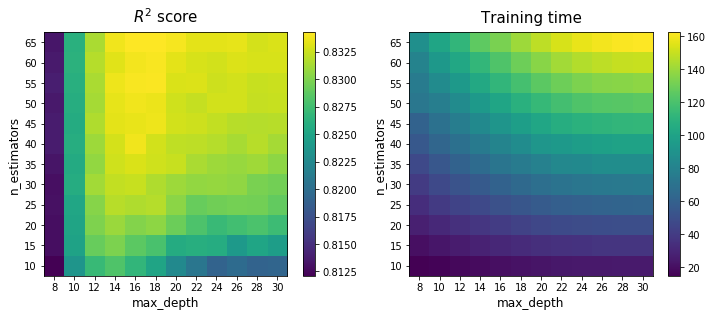

In [496]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=2)
score_plot = ax1.imshow(R2score, origin='lower')
ax1.set_xticks(range(len(depth)))
ax1.set_xticklabels([str(i) for i in depth])
ax1.set_yticks(range(len(n_tree)))
ax1.set_yticklabels(labels=[str(i) for i in n_tree])
fig.colorbar(score_plot, ax=ax1,shrink=.9)
ax1.set_xlabel('max_depth',fontsize=12)
ax1.set_ylabel('n_estimators',fontsize=12)
ax1.set_title(r'${R}^2$ score',fontsize=15,pad=10)

time_plot = ax2.imshow(fit_time, origin='lower')
ax2.set_xticks(range(len(depth)))
ax2.set_xticklabels([str(i) for i in depth])
ax2.set_yticks(range(len(n_tree)))
ax2.set_yticklabels(labels=[str(i) for i in n_tree])
fig.colorbar(time_plot, ax=ax2,shrink=.9)
ax2.set_xlabel('max_depth',fontsize=12)
ax2.set_ylabel('n_estimators',fontsize=12)
ax2.set_title('Training time',fontsize=15,pad=10)

fig.savefig('Optimization.pdf')

# Optimize K Nearest Neighbor parameters

In [17]:
### GridsearchCV
model = ML.KNeighborsRegressor()
param_grid = {'n_neighbors': np.arange(8,62,2).tolist(),
              'weights': ['uniform', 'distance']}
gscv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')

In [ ]:
start = time.time()
gscv.fit(col_shape, decals['mass_ir'])
print(time.time()-start)

$R^2$ score and training time plot


In [363]:
grid_scores = np.array(gscv.grid_scores_)
mscore = grid_scores[:,1]
scores = grid_scores[:,2]
params = grid_scores[:,0]
nneighbor = np.ones(len(params))
weight = np.full(len(params),None)
for i in range(len(params)):
    nneighbor[i] = params[i]['n_neighbors']
    weight[i] = params[i]['weights']

Text(0, 0.5, '$R^2$ score')

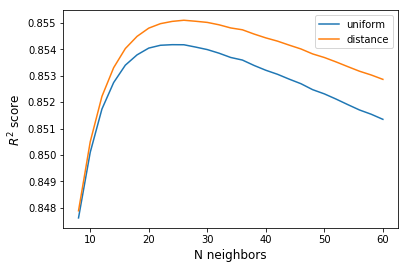

In [22]:
plt.plot(nneighbor[weight=='uniform'], mscore[weight=='uniform'], label='uniform')
plt.plot(nneighbor[weight=='distance'], mscore[weight=='distance'], label='distance')
plt.legend()
plt.xlabel('N neighbors',fontsize=12)
plt.ylabel('$R^2$ score',fontsize=12)

# Optimize Xgboost parameters

In [ ]:
### GridsearchCV
model = ML.XGBRegressor()
param_grid = {'max_depth': [3,5,7,9],
              'learning_rate': np.arange(0.08,0.16,0.01).tolist(),
              'objective': ['reg:linear','reg:gamma'],
              'booster': ['dart','gbtree']}
gscv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')

In [ ]:
start = time.time()
gscv.fit(col_shape, decals['mass_ir'])
print(time.time()-start)

In [42]:
## best parameters

array([{'booster': 'dart', 'learning_rate': 0.09999999999999999, 'max_depth': 9, 'objective': 'reg:linear'},
       0.8695793358274807,
       array([0.86727642, 0.86783382, 0.86687529, 0.87779234, 0.86811881])],
      dtype=object)

In [52]:
### GridsearchCV
model = ML.XGBRegressor()
param_grid = {'max_depth': [8,9],
              'learning_rate': [0.1],
              'objective': ['reg:linear'],
              'booster': ['dart'],
              'min_child_weight': [4,5,6]}
gscv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')

In [53]:
start = time.time()
gscv.fit(col_shape, decals['mass_ir'])
print(time.time()-start)

11317.498361110687


In [55]:
gscv.best_params_

{'booster': 'dart',
 'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_weight': 6,
 'objective': 'reg:linear'}

# Feature importance

In [344]:
col_shape = np.column_stack((decals['gmag']-decals['rmag'], decals['rmag']-decals['zmag'],
                             decals['zmag']-decals['w1mag'], decals['w1mag']-decals['w2mag'],
                             decals['gmag'], decals['axis_ratio'], decals['prob_exp'], decals['radius']))

In [435]:
reg = ML.Regressors(col_shape, decals['mass_ir'], train_size=0.8, test_size=0.2, random_state=2)

In [436]:
regknn = reg.KNN_dregressor(n_neighbors=26)
regrf = reg.RFregressor(n_estimators=60, max_depth=18)
regxgb = reg.Xgboostregressor(max_depth=9, min_child_weight=6)

Text(0.5, 1.0, 'Random Forest')

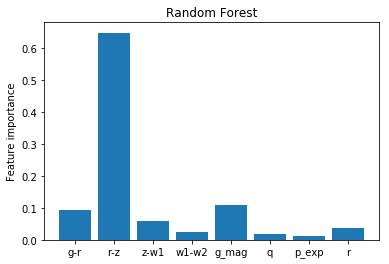

In [313]:
fi = regrf.meta['model'].feature_importances_
plt.bar(range(len(fi)), fi, tick_label = ['g-r', 'r-z', 'z-w1', 'w1-w2', 'g_mag', 'q', 'p_exp', 'r'])
plt.ylabel('Feature importance')
plt.title('Random Forest')

Text(0.5, 1.0, 'Xgboost')

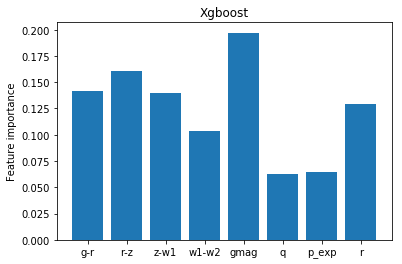

In [512]:
fi = regxgb.meta['model'].feature_importances_
plt.bar(range(len(fi)), fi, tick_label = ['g-r', 'r-z', 'z-w1', 'w1-w2', 'gmag', 'q', 'p_exp', 'r'])
plt.ylabel('Feature importance')
plt.title('Xgboost')

The built-in feature importance method may not always be reliable, below is permutation importance analysis

# Permutation importance

In [336]:
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

In [437]:
rfperm = PermutationImportance(regrf.meta['model']).fit(reg._Xtest, reg._Ytest)
xgbperm = PermutationImportance(regxgb.meta['model']).fit(reg._Xtest, reg._Ytest)
knnperm = PermutationImportance(regknn.meta['model']).fit(reg._Xtest, reg._Ytest)

Text(0.5, 1.0, 'Random Forest permutation importance')

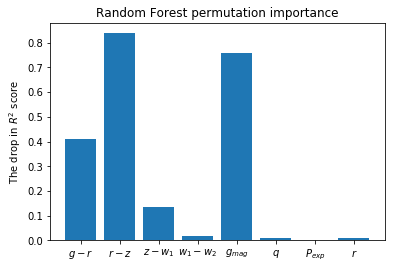

In [523]:
rffi = rfperm.feature_importances_
labels = ['$g-r$','$r-z$','$z-w_1$','$w_1-w_2$',
          '$g_{mag}$','$q$','$P_{exp}$','$r$']
plt.bar(np.arange(0,len(rffi))*1.5, rffi, width=1.2)
plt.ylabel('The drop in $R^2$ score', fontsize=10)
plt.xticks(ticks=np.arange(0,len(rffi))*1.5,
           labels=labels, size=10)
plt.title('Random Forest permutation importance', fontsize=12)
#plt.savefig('RF importance.pdf')

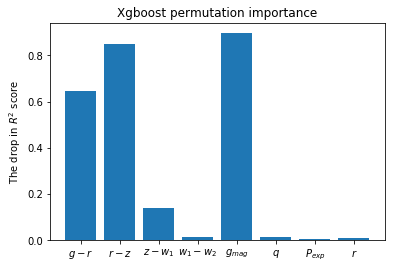

In [500]:
xgbfi = xgbperm.feature_importances_
plt.bar(np.arange(0,len(xgbfi))*1.5, xgbfi, width=1.2)
plt.ylabel('The drop in $R^2$ score', fontsize=10)
plt.xticks(ticks=np.arange(0,len(xgbfi))*1.5,
           labels=labels, size=10)
plt.title('Xgboost permutation importance', fontsize=12)
#plt.savefig('XGB importance.pdf')

Text(0.5, 1.0, 'KNN permutation importance')

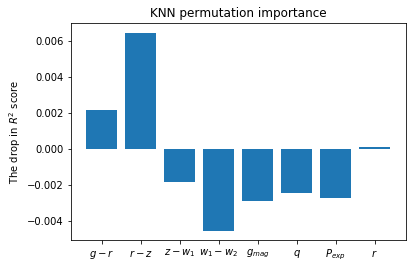

In [536]:
knnfi = knnperm.feature_importances_
plt.bar(np.arange(0,len(knnfi))*1.5, knnfi, width=1.2)
plt.ylabel('The drop in $R^2$ score', fontsize=10)
plt.xticks(ticks=np.arange(0,len(knnfi))*1.5,
           labels=labels, size=10)
plt.title('KNN permutation importance', fontsize=12)
#yplt.savefig('KNN importance.pdf')

# Correlation between mass and each feature

In [96]:
col_morph = col_shape.copy()
col_morph[:,-2] = decals['logprob_exp'] - decals['logprob_dev']

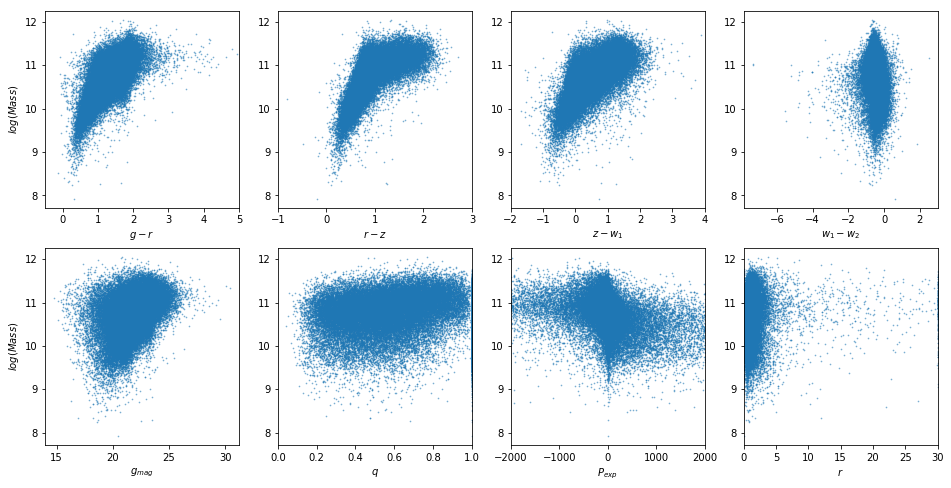

In [102]:
plt.figure(figsize=(16,8))
ax = [plt.subplot(2,4,i+1) for i in range(8)]
for i,axis in enumerate(ax):
    axis.scatter(col_morph[:,i][::10], decals['mass_ir'][::10], s=0.5, alpha=0.5)
    axis.set_xlabel(labels[i])
    if (i==0 or i==4):
        axis.set_ylabel('$log(Mass)$')
ax[0].set_xlim(-0.5,5)
ax[1].set_xlim(-1,3)
ax[2].set_xlim(-2,4)
ax[5].set_xlim(0,1)
ax[6].set_xlim(-2000,2000)
ax[7].set_xlim(0,30)
plt.savefig('Correlations.png')

In [316]:
a = np.column_stack((decals['gmag']-decals['rmag'], decals['rmag']-decals['zmag'],
                             decals['zmag']-decals['w1mag'], decals['w1mag']-decals['w2mag'],
                             decals['gmag'], decals['axis_ratio'], decals['prob_exp'], decals['radius']))

In [317]:
r = ML.Regressors(a[0:100000], decals['mass_ir'][0:100000],train_size=0.8,test_size=0.2,random_state=2)

In [318]:
knnt = r.RFregressor(n_estimators=100,scoring=True)
knnt.meta['R2']

0.8610903496462146